In [1]:
import utils as utils
import json
import copy
import torch.nn as nn
import torch
from dataloader.BSD500 import BSD500
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from torchmetrics.functional import structural_similarity_index_measure as ssim
import math
from matplotlib import pyplot as plt
import matplotlib.patches as patches

In [2]:
def compute_PSNR(img, imclean, data_range):
    Img = img.data.cpu().numpy().astype(np.float32)
    Iclean = imclean.data.cpu().numpy().astype(np.float32)
    PSNR = compare_psnr(Iclean[0,:,:,:], Img[0,:,:,:], data_range=data_range)
    return PSNR

class OpMRI(torch.nn.Module):


    def __init__(self, mask, device):

        super().__init__()

        self.mask = mask.long().to(device)

        self.device = device

    
    def forward(self, x):

        y = torch.fft.fft2(x, norm='ortho')*self.mask 

        return y


    def apply(self, x): 

        with torch.no_grad():
            y = torch.fft.fft2(x, norm='ortho')*self.mask

        return y 



    def applyJacobianT(self,v, x=None):

        with torch.no_grad():
            grad = torch.fft.ifft2(v*self.mask, norm='ortho')

        return torch.real(grad)


In [3]:
device = 'cpu'
add = '/home/pourya/all_methods/inverse_problems/mri/data/data_sets/multicoil_acc_8_cf_0.04_noisesd_0.002/pd/test_images/file1000182'
x = torch.load(add + '/x.pt').to(device)
y = torch.load(add + '/y.pt').to(device)
mask = torch.load(add + '/mask.pt').to(device)
smap =  torch.load(add + '/smaps.pt').to(device)
gt = torch.load(add + '/x_crop.pt').to(device)
mri = OpMRI(mask, device)
coil = 'multi'
if coil == 'single':
    x_z = torch.real(mri.applyJacobianT(y))
else:
    import sys
    sys.path += ['/home/pourya/all_methods/inverse_problems/mri/utils_mri/']
    from mri_forward_utils import OpMRI_multicoil_adjoint
    adj =  OpMRI_multicoil_adjoint(mask, torch.conj(smap), device)
    x_z = adj(y)
add = '/home/pourya/all_methods/inverse_problems/mri/test_data/recon/mri_coiltype_'
x_wcvx = torch.from_numpy(np.load(add + 'multi_acc_8_cf_0.04_noisesd_0.002_datatype_pd_weakconv/mri_coiltype_multi_acc_8_cf_0.04_noisesd_0.002_datatype_pd_weakconv_x_0.npy'))[None, None, :, :].to(device)
x_awcvx = torch.from_numpy(np.load(add + 'multi_acc_8_cf_0.04_noisesd_0.002_datatype_pd_mask_post_same/mri_coiltype_multi_acc_8_cf_0.04_noisesd_0.002_datatype_pd_mask_post_same_x_0.npy'))[None, None, :, :].to(device)
x_drunet = torch.from_numpy(np.load(add + 'multi_acc_8_cf_0.04_noisesd_0.002_datatype_pd_prox_drunet/mri_coiltype_multi_acc_8_cf_0.04_noisesd_0.002_datatype_pd_prox_drunet_x_0.npy'))[None, None, :, :].to(device)
x_cvx = torch.from_numpy(np.load(add + 'multi_acc_8_cf_0.04_noisesd_0.002_datatype_pd_crr_MRI_Sigma_25_t_10_K11/mri_coiltype_multi_acc_8_cf_0.04_noisesd_0.002_datatype_pd_crr_MRI_Sigma_25_t_10_K11_x_0.npy'))[None, None, :, :].to(device)
x_safi = torch.from_numpy(np.load(add + 'multi_acc_8_cf_0.04_noisesd_0.002_datatype_pd_mask_relax_sigma15/mri_coiltype_multi_acc_8_cf_0.04_noisesd_0.002_datatype_pd_mask_relax_sigma15_x_0.npy'))[None, None, :, :].to(device)
x_mmr =  torch.from_numpy(np.load(add + 'multi_acc_8_cf_0.04_noisesd_0.002_datatype_pd_mask_mm_sigma15/mri_coiltype_multi_acc_8_cf_0.04_noisesd_0.002_datatype_pd_mask_mm_sigma15_x_0.npy'))[None, None, :, :].to(device)

In [4]:
def center_crop(data, shape):
    w_from = (data.shape[-2] - shape[0]) // 2
    h_from = (data.shape[-1] - shape[1]) // 2
    w_to = w_from + shape[0]
    h_to = h_from + shape[1]
    return data[..., w_from:w_to, h_from:h_to]


x_crop_zf = center_crop(x_z, [320,320])
psnr_zf = compute_PSNR(x_crop_zf, gt, data_range=1)
ssim_zf = ssim(x_crop_zf, gt, data_range=1)
x_crop_wcvx  = center_crop(x_wcvx, [320,320])
psnr_wcvx = compute_PSNR(x_crop_wcvx, gt, data_range=1)
ssim_wcvx  = ssim(x_crop_wcvx, gt, data_range=1)
x_crop_awcvx = center_crop(x_awcvx, [320,320])
psnr_awcvx = compute_PSNR(x_crop_awcvx, gt, data_range=1)
ssim_awcvx = ssim(x_crop_awcvx, gt, data_range=1)
x_crop_drunet = center_crop(x_drunet, [320,320])
psnr_drunet = compute_PSNR(x_crop_drunet, gt, data_range=1)
ssim_drunet = ssim(x_crop_drunet, gt, data_range=1)
x_crop_cvx = center_crop(x_cvx, [320,320])
psnr_cvx = compute_PSNR(x_crop_cvx, gt, data_range=1)
ssim_cvx = ssim(x_crop_cvx, gt, data_range=1)
x_crop_mmrr = center_crop(x_mmr, [320,320])
psnr_mmrr = compute_PSNR(x_crop_mmrr, gt, data_range=1)
ssim_mmrr = ssim(x_crop_mmrr, gt, data_range=1)
x_crop_safi = center_crop(x_safi, [320,320])
psnr_safi = compute_PSNR(x_crop_safi, gt, data_range=1)
ssim_safi = ssim(x_crop_safi, gt, data_range=1)
print(psnr_zf, psnr_cvx, psnr_wcvx, psnr_awcvx, psnr_drunet, psnr_mmrr, psnr_safi)

22.661786187682722 30.371241349218067 33.15282160379433 33.67552751467508 33.66231136107798 32.326857683577266 33.68797828765024


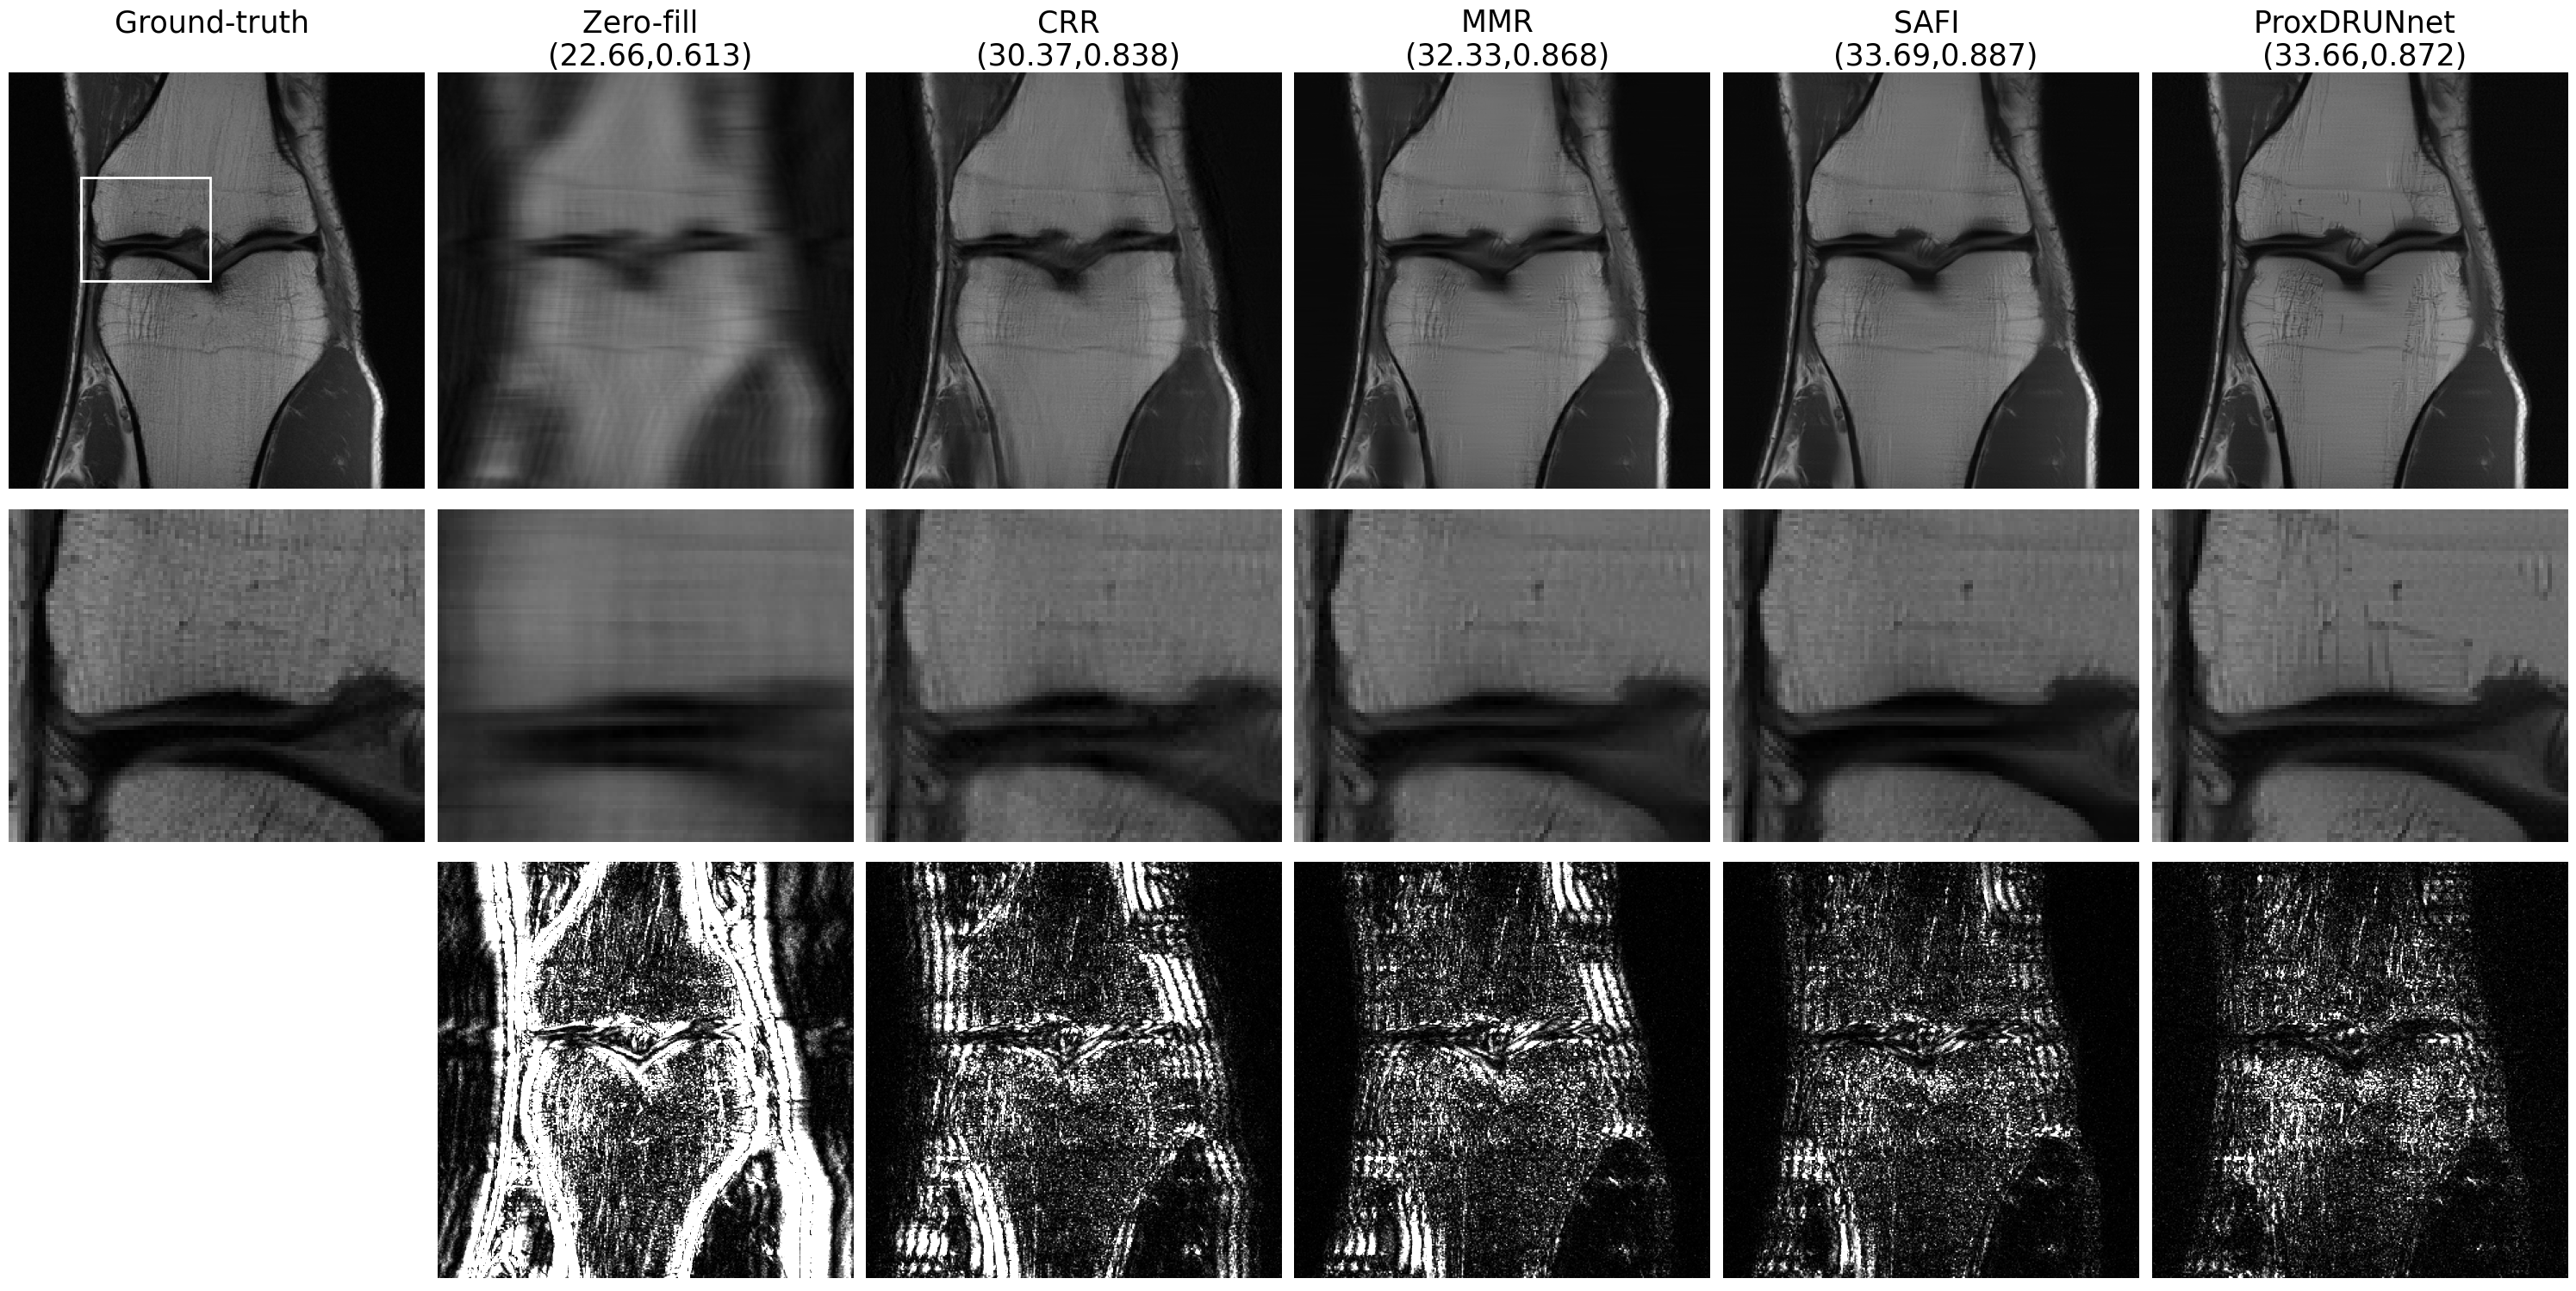

In [5]:
a= 80; c = 55; b=80; d = 100; 
vmax_ = 1
plt.figure(figsize=(30, 15))
ax = plt.subplot(361)
plt.imshow(gt[0, 0].cpu(), cmap='gray', vmax=vmax_)
plt.axis('off')
s = 25
plt.title('Ground-truth \n', size=s)
rect = patches.Rectangle((c, a), d, b, linewidth=2, edgecolor='white', facecolor='none')
ax.add_patch(rect)
plt.subplot(362)
plt.imshow(((x_crop_zf))[0, 0].cpu(), cmap='gray', vmax=vmax_)
plt.axis('off')
plt.title('Zero-fill \n (' + str(np.round(psnr_zf, 2)) + ',' + str(np.round(ssim_zf.cpu().item(), 3))+')', size=s)
plt.subplot(363)
plt.imshow(((x_crop_cvx))[0, 0].cpu(), cmap='gray', vmax=vmax_)
plt.axis('off')
plt.title('CRR \n (' + str(np.round(psnr_cvx, 2)) + ',' + str(np.round(ssim_cvx.cpu().item(), 3))+')', size=s)
plt.subplot(364)
plt.imshow(((x_crop_mmrr))[0, 0].cpu(), cmap='gray', vmax=vmax_)
plt.axis('off')
plt.title('MMR \n (' + str(np.round(psnr_mmrr, 2)) + ',' + str(np.round(ssim_mmrr.cpu().item(), 3))+')', size=s)
plt.subplot(365)
plt.imshow(((x_crop_safi))[0, 0].cpu(), cmap='gray', vmax=vmax_)
plt.axis('off')
plt.title('SAFI \n (' + str(np.round(psnr_safi, 2)) + ',' + str(np.round(ssim_safi.cpu().item(), 3))+')', size=s)
plt.subplot(366)
plt.imshow(((x_crop_drunet))[0, 0].cpu(), cmap='gray', vmax=vmax_)
plt.axis('off')
plt.title('ProxDRUNnet \n (' + str(np.round(psnr_drunet, 2)) + ',' + str(np.round(ssim_drunet.cpu().item(), 3))+')', size=s)

plt.subplot(367)
plt.imshow(gt[0, 0, a:a+b, c:c+d].cpu(), cmap='gray', vmax=vmax_)
plt.axis('off')
plt.subplot(368)
plt.imshow(((x_crop_zf))[0, 0, a:a+b, c:c+d].cpu(), cmap='gray', vmax=vmax_)
plt.axis('off')
plt.subplot(369)
plt.imshow(((x_crop_cvx))[0, 0, a:a+b, c:c+d].cpu(), cmap='gray', vmax=vmax_)
plt.axis('off')
plt.subplot(3,6, 10)
plt.imshow(((x_crop_mmrr))[0, 0, a:a+b, c:c+d].cpu(), cmap='gray', vmax=vmax_)
plt.axis('off')
plt.subplot(3,6,11)
plt.imshow(((x_crop_safi))[0, 0, a:a+b, c:c+d].cpu(), cmap='gray', vmax=vmax_)
plt.axis('off')
plt.subplot(3,6,12)
plt.imshow(((x_crop_drunet))[0, 0, a:a+b, c:c+d].cpu(), cmap='gray', vmax=vmax_)
plt.axis('off')

vmax_ = 0.003
plt.subplot(3, 6, 13)
plt.axis('off')
'''plt.xticks([])
plt.yticks([])
plt.ylabel('residual', size=20)'''
plt.subplot(3, 6, 14)
plt.imshow(((x_crop_zf-gt)**2)[0, 0].cpu(), cmap='gray', vmax=vmax_)
plt.axis('off')
plt.subplot(3, 6, 15)
plt.imshow(((x_crop_cvx-gt)**2)[0, 0].cpu(), cmap='gray', vmax=vmax_)
plt.axis('off')
plt.subplot(3, 6, 16)
plt.imshow(((x_crop_mmrr-gt)**2)[0, 0].cpu(), cmap='gray', vmax=vmax_)
plt.axis('off')
plt.subplot(3, 6, 17)
plt.imshow(((x_crop_safi-gt)**2)[0, 0].cpu(), cmap='gray', vmax=vmax_)
plt.axis('off')
plt.subplot(3, 6, 18)
plt.imshow(((x_crop_drunet-gt)**2)[0, 0].cpu(), cmap='gray', vmax=vmax_)
plt.axis('off')
plt.subplots_adjust(wspace=0.1, hspace=0)
plt.tight_layout()
plt.savefig('fig_data/mri_multi_pd_final.pdf', bbox_inches="tight")
plt.show()
